In [2]:
########## Calling relevant libraries ##########
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import scipy

import pandas as pd

import sklearn
import sklearn.model_selection as model_selection
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor

import sqlite3
import rampy as rp

import sys
sys.path.append("/Users/charles/GoogleDrive/viscopy/")
import viscopy as vp

import h5py

/Users/charles/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# FULL DATASET
#con = sqlite3.connect('./data/viscosity.sqlite')

#dataset = pd.read_sql_query("SELECT * from viscosity", con)
#con.close() # closing the sql connection

# KNAS, comment to deactivate
dataset = pd.read_excel("./data/Database_IPGP.xlsx")
dataset.head()

dataset = vp.chimie_control(dataset)
ap, b = vp.heatcp(dataset,dataset.tg)

dataset['ap'] = ap
dataset['b'] = b
dataset.head()

,sio2,al2o3,fe2o3,li2o,na2o,k2o,mgo,cao,feo,tg,...,Be,Sc,tio2,h2o,bao,nio,mno,p2o5,ap,b
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1480.0,...,143837.721911,6.812523,0.0,0.0,0.0,0.0,0.0,0.0,6.544,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1480.0,...,143837.721911,6.812523,0.0,0.0,0.0,0.0,0.0,0.0,6.544,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1480.0,...,143837.721911,6.812523,0.0,0.0,0.0,0.0,0.0,0.0,6.544,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1480.0,...,143837.721911,6.812523,0.0,0.0,0.0,0.0,0.0,0.0,6.544,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1480.0,...,143837.721911,6.812523,0.0,0.0,0.0,0.0,0.0,0.0,6.544,0.0


In [4]:
tv_sub, test_sub, idxtv_sub, idxtest_sub = rp.chemical_splitting(dataset,'tg',0.15, rand_state=81)

#train_sub, valid_sub = model_selection.train_test_split(dataset,test_size=0.3,shuffle=True)

valid_sub, train_sub, idxvalid_sub, idxtrain_sub = rp.chemical_splitting(tv_sub,'tg',0.85, rand_state=100)

y_train = train_sub["viscosity"].values.reshape(-1,1)
y_valid = valid_sub["viscosity"].values.reshape(-1,1)
y_tv = tv_sub["viscosity"].values.reshape(-1,1)
y_test = test_sub["viscosity"].values.reshape(-1,1)

# FOR KNAS : CHOICE
X_columns = ["sio2","al2o3","na2o","k2o","ap","b","T","Be","Sc","tg"]
# For all data, select "sio2":"T"

X_train = train_sub.loc[:,X_columns].values
X_valid = valid_sub.loc[:,X_columns].values
X_tv = tv_sub.loc[:,X_columns].values
X_test = test_sub.loc[:,X_columns].values

In [5]:
# parameters for neural net
prm_nn = dict(hidden_layer_sizes=(100,),solver = 'lbfgs',activation='relu',early_stopping=True)
param_b = dict(n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=1, verbose=0)

model = rp.mlregressor(X_tv,y_tv,algorithm="BaggingNeuralNet"
                        , scaler = "StandardScaler",X_test = X_valid, y_test = y_valid,
                       param_neurons=prm_nn,param_bagging=param_b,rand_state=100)

model.fit()
# we grab the scaling from rp.mlregressor

In [6]:
X_train_sc = model.X_scaler.transform(X_train)
y_train_sc = model.Y_scaler.transform(y_train.reshape(-1,1))

X_valid_sc = model.X_scaler.transform(X_valid)
y_valid_sc = model.Y_scaler.transform(y_valid.reshape(-1,1))

X_test_sc = model.X_scaler.transform(X_test)
y_test_sc = model.Y_scaler.transform(y_test.reshape(-1,1))

# we ensure that only the chemistry was standardized
X_train_sc[:,4:] = X_train[:,4:]
X_valid_sc[:,4:] = X_valid[:,4:]
X_test_sc[:,4:] = X_test[:,4:]

In [7]:
MSE_NN_train = np.sqrt(mean_squared_error(model.y_train, model.prediction_train))
MSE_NN_valid = np.sqrt(mean_squared_error(model.y_test, model.prediction_test))

print("training and testing RMSE with neural nets")
print(MSE_NN_train)
print(MSE_NN_valid)


training and testing RMSE with neural nets
0.08105024954437424
0.09148745446600301


In [8]:
print("X training and validation set shape, unscaled and scaled")
print(X_train.shape)
print(X_train_sc.shape)

print(X_valid.shape)
print(X_valid_sc.shape)

print("X test set shape, unscaled and scaled")
print(X_test.shape)
print(X_test_sc.shape)

X training and validation set shape, unscaled and scaled
(598, 10)
(598, 10)
(91, 10)
(91, 10)
X test set shape, unscaled and scaled
(128, 10)
(128, 10)


/Users/charles/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


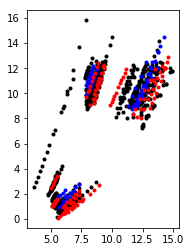

In [9]:
plt.subplot(121)
plt.plot(10000/X_train[:,6],y_train,"k.")

plt.subplot(121)
plt.plot(10000/X_valid[:,6],y_valid,"b.")

plt.subplot(121)
plt.plot(10000/X_test[:,6],y_test,"r.")

In [11]:
with h5py.File('./data/DataSet.hdf5', 'w') as f:
    f.create_dataset('X_columns', data=np.array(X_columns, dtype="S10"))
    
    f.create_dataset('X_tv', data=X_tv)
    f.create_dataset('y_tv', data=y_tv)
    
    f.create_dataset('X_train', data=X_train)
    f.create_dataset('X_train_sc', data=X_train_sc)
    
    f.create_dataset('y_train', data=y_train)
    f.create_dataset('y_train_sc', data=y_train_sc)
    
    f.create_dataset('X_valid', data=X_valid)
    f.create_dataset('X_valid_sc', data=X_valid_sc)
    
    f.create_dataset('y_valid', data=y_valid)
    f.create_dataset('y_valid_sc', data=y_valid_sc)
    
    f.create_dataset('X_test', data=X_test)
    f.create_dataset('X_test_sc', data=X_test_sc)
    
    f.create_dataset('y_test', data=y_test)
    f.create_dataset('y_test_sc', data=y_test_sc)
    
    f.create_dataset('X_scaler_mean', data=model.X_scaler.mean_)
    f.create_dataset('X_scaler_var', data=model.X_scaler.var_)
    
    f.create_dataset('y_scaler_mean', data=model.Y_scaler.mean_)
    f.create_dataset('y_scaler_var', data=model.Y_scaler.var_)

    

In [50]:
np.array_equal((X_tv-model.X_scaler.mean_)/np.sqrt(model.X_scaler.var_),X_tv_sc)

True